# Spectrogram Diffusion Transposition Test

The purpose of this notebook is to test the effects of transposition on the embedding space of the Spectrogram Diffusion model. I've done this by transposing MIDI files and looking at the difference between the embeddings of the transposed and untransposed, or "base" versions, which im calling delta vectors. We'd hope to see something like the delta vector between an upwards transposition and downwards transposition having similar magnitude and near opposite direction. Also, ideally the embeddings of two different segments should exhibit similar changes when transformed similarly.

## imports

In [30]:
import os
import sys
import pretty_midi
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from numpy.linalg import norm
from scipy.stats import entropy
from itertools import combinations


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import basename
from src.utils.midi import transpose_midi
from src.utils.constants import NOTE_NAMES
from src.ml.specdiff.model import SpectrogramDiffusion

## setup
### parameters

In [31]:
np.random.seed(0)

# DATA_DIR = "/media/scratch/sageev-midi/20250410/augmented"
DATA_DIR = "/media/scratch/sageev-midi/teeny/ccsf"
# temporary directory for transposed files
TMP_DIR = "/home/finlay/disklavier/tests/outputs/tmp"
os.makedirs(TMP_DIR, exist_ok=True)

model = SpectrogramDiffusion(fix_time=False, verbose=False)

base_files = glob(os.path.join(DATA_DIR, "*.mid"))
base_files.sort()

# chosen_files = np.random.choice(base_files, size=12, replace=False)
chosen_files = base_files
transposition_pattern = re.compile(r"_t(\d+)s\d+\.mid$")

all_results = []
chosen_files

04-29 19:59:39.903700 spcdif: initializing spectrogram diffusion model                                  ]8;id=101695;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=775638;file:///home/finlay/disklavier/src/ml/specdiff/model.py#56\56]8;;\

04-29 19:59:41.127417 spcdif: model initialization complete                                             ]8;id=400547;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=575880;file:///home/finlay/disklavier/src/ml/specdiff/model.py#87\87]8;;\

['/media/scratch/sageev-midi/teeny/ccsf/full_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/full_47_c3.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/full_47_c4.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/half_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/half_47_c3.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/half_47_c4.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/quarter_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/quarter_47_c3.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/quarter_47_c4.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/run_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/run_47_c3.mid',
 '/media/scratch/sageev-midi/teeny/ccsf/run_47_c4.mid']

### selected files
its not clear from these images, but "half" and "quarter" files are composed of half and quarter notes respectively. Since i made them in ableton the note ends and starts are at the same time.

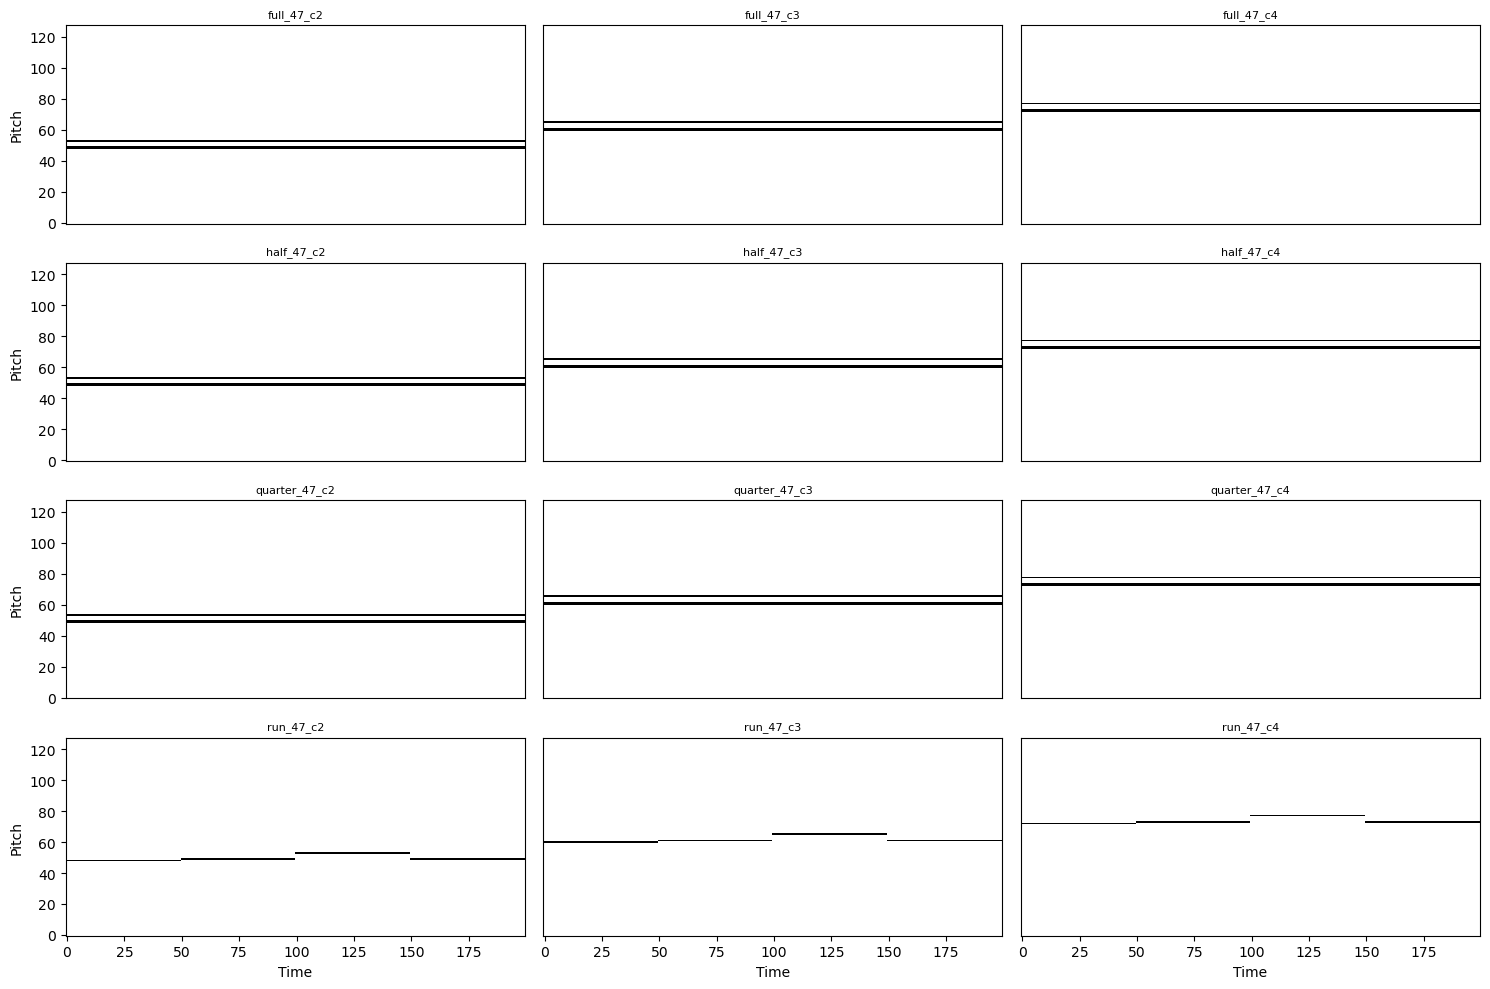

In [32]:
# Plot piano rolls of all chosen files in a 3x4 grid
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for i, file_path in enumerate(chosen_files):
    if i >= 12:  # Ensure we only plot 12 files
        break

    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Get piano roll (fs=100 means 100 samples per second)
    piano_roll = midi_data.get_piano_roll(fs=100)

    # Plot piano roll
    im = axes[i].imshow(
        piano_roll,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        interpolation="nearest",
    )

    # Set title to the filename (basename only)
    axes[i].set_title(basename(file_path), fontsize=8)

    # Set y-axis (pitch) labels for leftmost plots only
    if i % 3 == 0:
        axes[i].set_ylabel("Pitch")
    else:
        axes[i].set_yticks([])

    # Set x-axis (time) labels for bottom plots only
    if i >= 9:
        axes[i].set_xlabel("Time")
    else:
        axes[i].set_xticks([])

plt.tight_layout()
plt.show()

## helper functions

In [33]:
def get_pitch_histogram(midi_path, normalize=True, smooth=1e-6):
    """
    calculate the pitch histogram for a midi file over the full pitch range (0-127).

    parameters
    ----------
    midi_path : str
        path to the midi file.
    smooth : float
        smoothing factor added to all bins to avoid zeros.

    returns
    -------
    np.ndarray or none
        normalized pitch histogram (128 bins), or none if midi cannot be loaded.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    # Initialize histogram for pitches 0-127
    hist = np.zeros(128)
    for instrument in midi_data.instruments:
        if not instrument.is_drum:  # Optional: ignore drums
            for note in instrument.notes:
                # Ensure pitch is within valid range
                if 0 <= note.pitch <= 127:
                    if normalize:
                        hist[note.pitch] += (
                            note.end - note.start
                        )  # Use duration as weight
                    else:
                        hist[note.pitch] += 1

    if normalize:
        # Use total non-zero duration for normalization, or 1 if total duration is 0
        total_duration = hist.sum()
        # Add smoothing and normalize by duration
        hist += smooth * total_duration  # Scale smoothing by total duration
        hist /= hist.sum()

    return hist


def shift_histogram(hist, offset):
    """
    circularly shift a pitch histogram.

    parameters
    ----------
    hist : np.ndarray
        the pitch histogram (12 bins).
    offset : int
        the number of semitones to shift (positive or negative).

    returns
    -------
    np.ndarray
        the shifted histogram.
    """
    return np.roll(hist, offset)


def calculate_kl_divergence(p, q):
    """
    calculate kl divergence d_kl(p || q).

    parameters
    ----------
    p : np.ndarray
        first probability distribution.
    q : np.ndarray
        second probability distribution.

    returns
    -------
    float
        the kl divergence.
    """
    return entropy(p, q)


def plot_individual_difference(
    ax,
    df,
    title_prefix,
    offset=None,
    mag_label="Magnitude Diff",
    cos_label="Cosine Diff",
):
    """
    plot magnitude and cosine difference on primary and secondary y-axes using seaborn.

    parameters
    ----------
    ax : matplotlib.axes._axes.axes
        the axes to plot on.
    df : pd.dataframe
        dataframe containing 'transposition', 'magnitude difference', and 'cosine difference'.
    title_prefix : str
        prefix for the plot title.
    offset : int, optional
        transposition offset used for aligned plots. defaults to none.
    mag_label : str, optional
        label for the magnitude difference axis.
    cos_label : str, optional
        label for the cosine difference axis.
    """
    # Primary axis (Magnitude Difference)
    sns.lineplot(
        data=df,
        x="Transposition",
        y="Magnitude Difference",
        marker="o",
        label=mag_label,
        color="tab:blue",
        ax=ax,
    )
    ax.set_xlabel("Transposition (Semitones)")
    ax.set_ylabel(mag_label, color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.grid(True, linestyle=":")

    # Secondary axis (Cosine Difference)
    ax2 = ax.twinx()
    sns.lineplot(
        data=df,
        x="Transposition",
        y="Cosine Difference",
        marker="s",
        linestyle="--",
        label=cos_label,
        color="tab:orange",
        ax=ax2,
    )
    ax2.set_ylabel(cos_label, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax2.set_ylim(0, 1)  # Set specific limits if needed for cosine diff

    # Title and Legend
    if offset is not None:
        ax.set_title(f"{title_prefix} (Aligned, Offset={offset})", fontsize=10)
        ax.set_xlabel("Original Transposition Label (Semitones)")
    else:
        ax.set_title(f"{title_prefix}", fontsize=10)

    # Combine legends from both axes
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc="best")
    ax.get_legend().remove()
    ax2.get_legend().remove()


def plot_heatmaps(embeddings_matrix, file_labels=None, transpose_labels=None):
    """
    generate heatmaps comparing embeddings between pairs of files across transpositions.

    parameters
    ----------
    embeddings_matrix : np.ndarray
        3d array of shape (n_files, n_transposes, len_embedding).
    file_labels : list[str], optional
        labels for the files (rows of the matrix).
    transpose_labels : list[str | int], optional
        labels for the transpositions (columns within each file).

    returns
    -------
    none
        displays the generated heatmaps.
    """
    n_files, n_transposes, _ = embeddings_matrix.shape

    if file_labels is None:
        file_labels = [f"file {i+1}" for i in range(n_files)]
    if transpose_labels is None:
        transpose_labels = list(range(n_transposes))

    # ensure labels match dimensions
    if len(file_labels) != n_files:
        raise ValueError(
            f"number of file labels ({len(file_labels)}) does not match number of files ({n_files})"
        )
    if len(transpose_labels) != n_transposes:
        raise ValueError(
            f"number of transpose labels ({len(transpose_labels)}) does not match number of transpositions ({n_transposes})"
        )

    for i, j in combinations(range(n_files), 2):
        file_i_embeddings = embeddings_matrix[i, :, :]
        file_j_embeddings = embeddings_matrix[j, :, :]

        magnitude_diff_matrix = np.zeros((n_transposes, n_transposes))
        cosine_sim_matrix = np.zeros((n_transposes, n_transposes))

        for t1 in range(n_transposes):
            for t2 in range(n_transposes):
                vec_i_t1 = file_i_embeddings[t1, :]
                vec_j_t2 = file_j_embeddings[t2, :]

                # magnitude difference
                magnitude_diff_matrix[t1, t2] = norm(vec_i_t1 - vec_j_t2)

                # cosine similarity
                norm_i_t1 = norm(vec_i_t1)
                norm_j_t2 = norm(vec_j_t2)
                if norm_i_t1 > 1e-9 and norm_j_t2 > 1e-9:  # check for non-zero vectors
                    cosine_sim = np.dot(vec_i_t1, vec_j_t2) / (norm_i_t1 * norm_j_t2)
                    # clip to handle potential floating point inaccuracies
                    cosine_sim_matrix[t1, t2] = np.clip(cosine_sim, -1.0, 1.0)
                else:
                    # assign 0 similarity if one or both vectors are zero
                    cosine_sim_matrix[t1, t2] = 0.0

        # plotting
        fig, axes = plt.subplots(
            1, 2, figsize=(16, 7)
        )  # increased figure size slightly

        # magnitude difference heatmap
        sns.heatmap(
            magnitude_diff_matrix,
            annot=True,
            fmt=".2f",
            cmap="viridis_r",  # reversed viridis: lower distance = brighter
            ax=axes[0],
            xticklabels=transpose_labels,
            yticklabels=transpose_labels,
            square=True,  # make cells square
            linewidths=0.5,  # add lines between cells
            cbar_kws={"shrink": 0.8},  # shrink color bar slightly
        )
        axes[0].set_title(f"magnitude difference")
        axes[0].set_xlabel(f"transpose index ({file_labels[j]})")
        axes[0].set_ylabel(f"transpose index ({file_labels[i]})")
        axes[0].tick_params(axis="x", rotation=45)
        axes[0].tick_params(axis="y", rotation=0)

        # cosine similarity heatmap
        sns.heatmap(
            cosine_sim_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",  # good for similarity (-1 to 1)
            ax=axes[1],
            vmin=-1,  # set range for cosine similarity
            vmax=1,
            xticklabels=transpose_labels,
            yticklabels=transpose_labels,
            square=True,  # make cells square
            linewidths=0.5,  # add lines between cells
            cbar_kws={"shrink": 0.8},  # shrink color bar slightly
        )
        axes[1].set_title(f"cosine similarity")
        axes[1].set_xlabel(f"transpose index ({file_labels[j]})")
        axes[1].set_ylabel(f"transpose index ({file_labels[i]})")
        axes[1].tick_params(axis="x", rotation=45)
        axes[1].tick_params(axis="y", rotation=0)

        title_suffix = f"{file_labels[i]} vs {file_labels[j]}"
        fig.suptitle(
            title_suffix,
            fontsize=16,
        )
        fig.tight_layout(
            rect=(0, 0.03, 1, 0.95)
        )  # adjust layout to prevent title overlap
        plt.show()

## upwards/downwards transposition test

lets compare upwards and downwards transposition delta vectors using the base file "full_47_c2", which is one bar of [C2, D2, E2] at 47bpm (just over 5 seconds). So for transposition 1 we'll look at the embeddings of the base file once its been transposed upwards and downwards by one step, repeat for all transpositions up and including 12.

In [34]:
all_embeddings = []
for t in range(13):
    tmp_path_up = os.path.join(TMP_DIR, basename(chosen_files[0]) + f"_u{t:02d}.mid")
    tmp_path_down = os.path.join(TMP_DIR, basename(chosen_files[0]) + f"_d{t:02d}.mid")
    transpose_midi(chosen_files[0], tmp_path_up, t)
    transpose_midi(chosen_files[0], tmp_path_down, -t)
    embedding_up = model.embed(tmp_path_up).squeeze().flatten()
    embedding_down = model.embed(tmp_path_down).squeeze().flatten()
    all_embeddings.append((embedding_up, embedding_down))
all_embeddings = np.array(all_embeddings)

print(f"transposition    magnitude    cosine_diff")
print("-" * 45)
for transposition, row in enumerate(all_embeddings):
    embedding_up, embedding_down = row
    diff_vector = embedding_up - embedding_down
    magnitude_diff = norm(diff_vector)
    cosine_diff = np.dot(embedding_up, embedding_down) / (
        norm(embedding_up) * norm(embedding_down)
    )
    print(f"     {transposition:02d}\t\t{magnitude_diff:8.05f}     {cosine_diff:8.05f}")

transposition    magnitude    cosine_diff
---------------------------------------------
     00		 0.00000      1.00000
     01		 3.76195      0.41186
     02		 3.37574      0.56175
     03		 3.59583      0.49911
     04		 4.81292      0.18772
     05		 4.15446      0.31921
     06		 3.76406      0.42451
     07		 3.48415      0.43406
     08		 4.39881      0.27819
     09		 3.69016      0.43573
     10		 3.86195      0.34238
     11		 4.08245      0.29569
     12		 4.19494      0.25674


hm. not really what i had hoped for. lets press on.

## cross-file delta comparisons
now lets take each file, transpose it upwards by up to 12 semitones, and see how its embeddings change with respect to its base embedding


### per-file plots

each sub-plot in the plot below shows how the delta vector moves as the file is transposed upwards.

Processing base file: full_47_c2
 Transposition  Magnitude Difference  Cosine Difference
             0              0.000000       5.960464e-08
             1              2.899915       3.515130e-01
             2              3.753779       5.696922e-01
             3              3.835794       5.723501e-01
             4              4.325619       6.486064e-01
             5              3.483631       4.917043e-01
             6              4.003836       6.344549e-01
             7              3.507203       5.292104e-01
             8              4.508969       7.482967e-01
             9              3.829626       5.974175e-01
            10              4.191846       7.167993e-01
            11              4.105251       6.785045e-01
            12              3.924474       6.027777e-01
----------------------------------------------------------------------
Processing base file: full_47_c3
 Transposition  Magnitude Difference  Cosine Difference
             0         

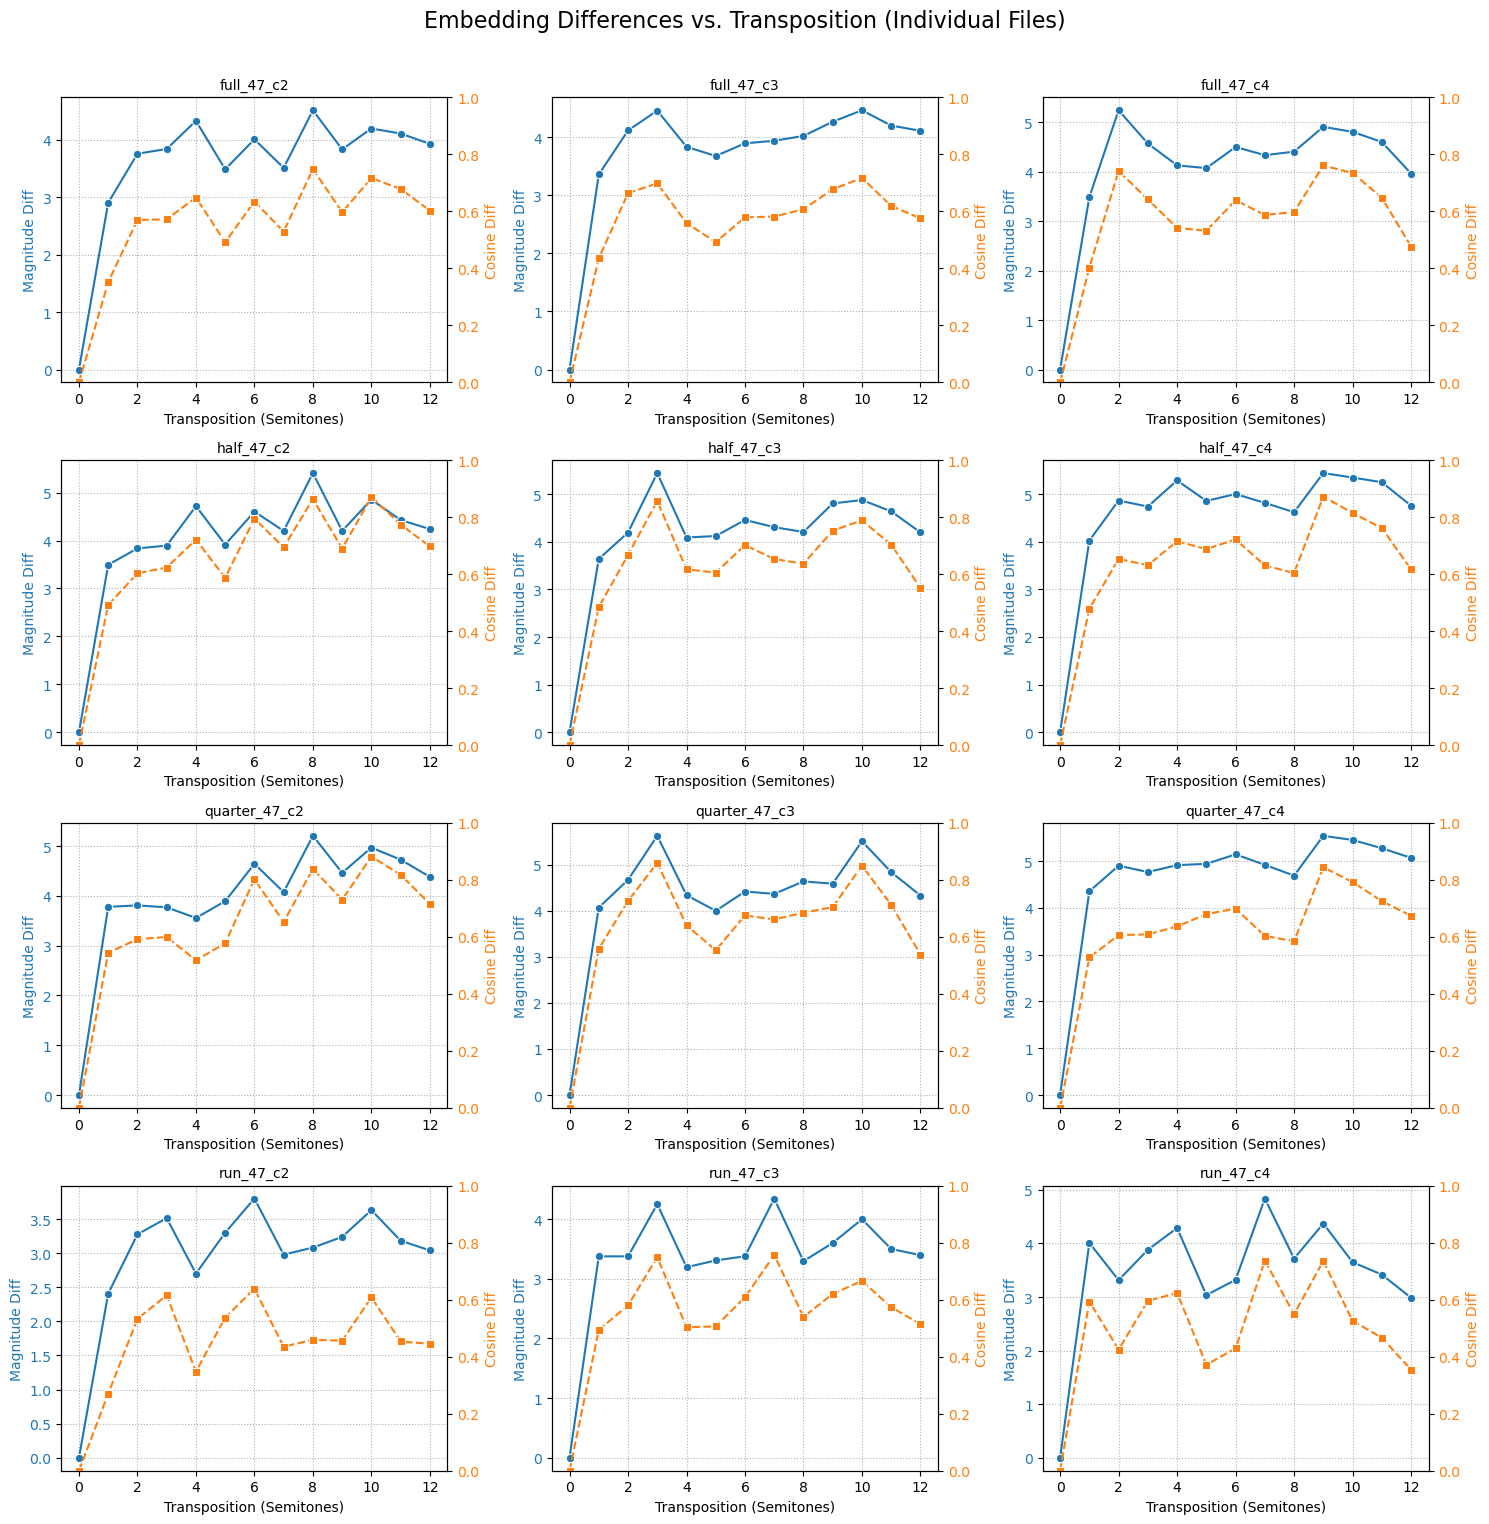

In [35]:
# Plotting setup for individual files
n_files = len(chosen_files)
n_cols = 3
n_rows = (n_files + n_cols - 1) // n_cols
fig_individual, axes_individual = plt.subplots(
    n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False
)
axes_individual = axes_individual.flatten()

all_diffs = np.zeros((n_files, 13, 768))
all_prs = []

for i, base_file in enumerate(chosen_files):
    print(f"Processing base file: {basename(base_file)}")
    try:
        base_embedding = model.embed(base_file).squeeze().flatten()
    except Exception as e:
        print(f"  Error getting embedding for base file {basename(base_file)}: {e}")
        continue

    base_name_prefix = basename(base_file)
    # base_name_prefix = basename(base_file).replace("_t00s00", "")
    # related_files = glob(os.path.join(DATA_DIR, f"{base_name_prefix}_t*s00.mid"))
    # related_files.sort()
    # related_files.append(f"{base_name_prefix}_t12s00.mid")
    related_files = [basename(base_file) + f"_t{t:02d}s00.mid" for t in range(13)]

    results = []
    transpositions_found = []
    all_diffs[i, 0, :] = np.zeros_like(base_embedding)

    for j, f in enumerate(related_files):
        match = transposition_pattern.search(f)
        if match:
            transposition = int(match.group(1))
            transpositions_found.append(transposition)

            try:
                tmp_path = f"/home/finlay/disklavier/tests/outputs/tmp/{basename(f)}"
                transpose_midi(base_file, tmp_path, transposition)
                if i == 0:
                    all_prs.append(
                        pretty_midi.PrettyMIDI(tmp_path).get_piano_roll(fs=10)
                    )
                transposed_embedding = model.embed(tmp_path).squeeze()
                diff_vector = transposed_embedding - base_embedding
                all_diffs[i, j, :] = diff_vector
                magnitude_diff = norm(diff_vector)

                # Cosine similarity calculation, handle potential zero vectors
                norm_base = norm(base_embedding)
                norm_transposed = norm(transposed_embedding)
                cosine_sim = np.dot(base_embedding, transposed_embedding) / (
                    norm_base * norm_transposed
                )

                # Ensure cosine similarity is within [-1, 1] due to potential floating point errors
                cosine_sim = np.clip(cosine_sim, -1.0, 1.0)
                cosine_diff = 1 - cosine_sim

                results.append(
                    {
                        "Transposition": transposition,
                        "Magnitude Difference": magnitude_diff,
                        "Cosine Difference": cosine_diff,
                        "File": basename(f),  # Keep track of the specific file
                    }
                )

            except Exception as e:
                print(f"    Error processing {basename(f)}: {e}")
                continue

    # Sort results by transposition for consistent table/plotting
    results.sort(key=lambda x: x["Transposition"])

    # Print table for the current base file
    df_results = pd.DataFrame(results)
    print(
        df_results.to_string(
            index=False,
            columns=["Transposition", "Magnitude Difference", "Cosine Difference"],
        )
    )
    print("-" * 70)

    # Add base file info to results before extending the main list
    for res in results:
        res["BaseFile"] = base_name_prefix

    # Store for aggregate plot
    all_results.extend(results)

    # Plotting for individual file
    ax = axes_individual[i]
    plot_individual_difference(
        ax,
        df_results,
        base_name_prefix,
        mag_label="Magnitude Diff",
        cos_label="Cosine Diff",
    )
# Clean up empty subplots for individual plots
for j in range(i + 1, len(axes_individual)):
    fig_individual.delaxes(axes_individual[j])

fig_individual.suptitle(
    "Embedding Differences vs. Transposition (Individual Files)", fontsize=16
)
fig_individual.tight_layout(rect=(0, 0.03, 1, 0.97))
fig_individual.show()

ok this is pretty interesting. we are seeing a drop in the delta vector at 12 semitones, which is expected, however i can't make sense of pretty much any of the other details. a few examples:
1. pretty much every example has a drop at 2 semitones, is that musically significant?
2. if you ignore the bottom row, the other three files all spike at 9 semitones when they're transposed down an octave (thats what the `c2` suffix means), but that goes away at the higher octaves. why???
3. in general i would have hoped the deltas would have been more consistent from left to right as we increase the octaves.

### transposition verification
just confirming that the transpositions are doing what we think they're doing :)

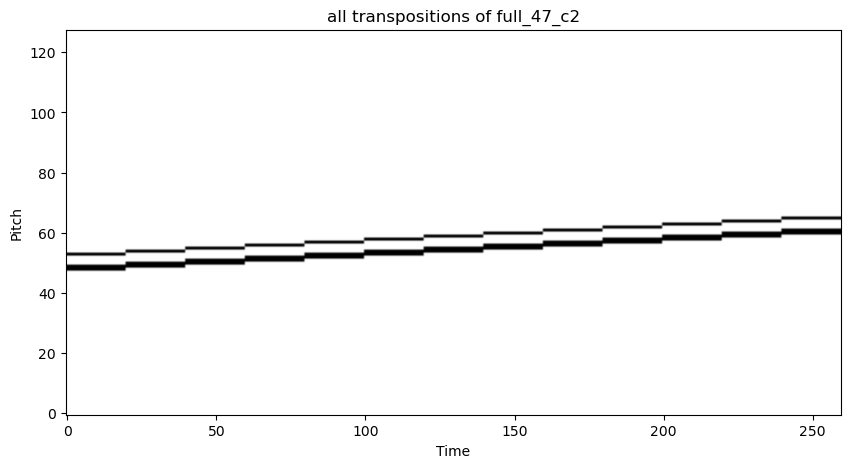

In [36]:
plt.figure(figsize=(10, 5))
plt.imshow(np.hstack(all_prs), cmap="gray_r", aspect="auto", origin="lower")
plt.title(f"all transpositions of {basename(chosen_files[0])}")
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.show()

### aggregate plot

this is just the big orange and blue plots from before, overlaid

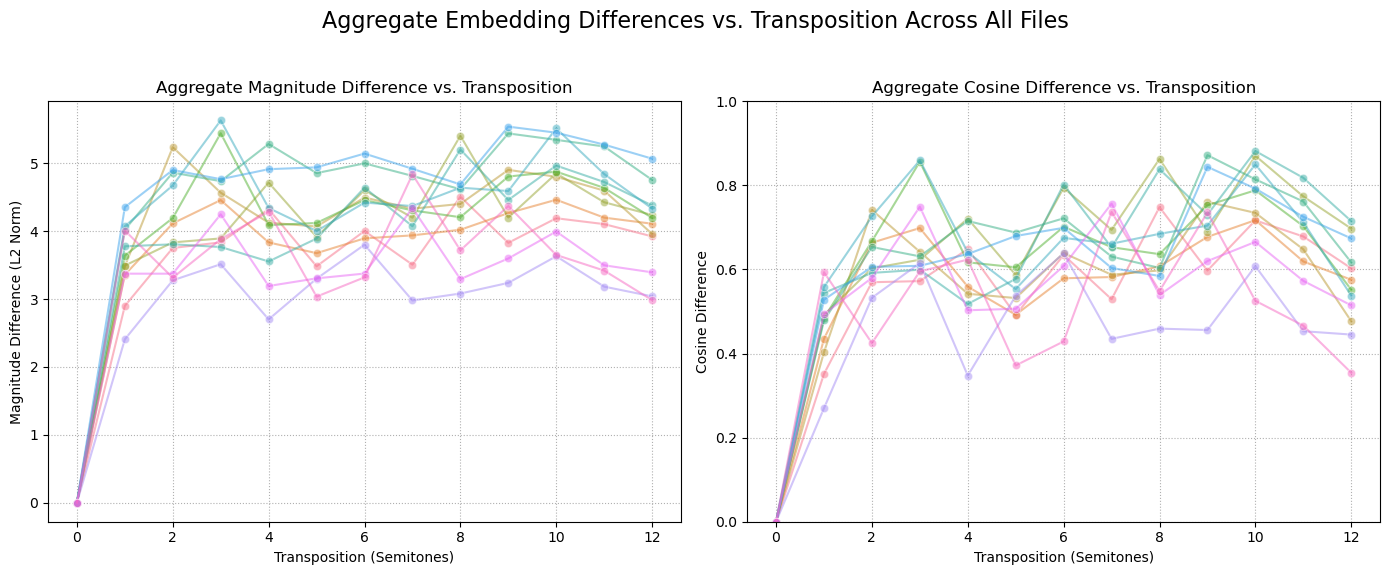

In [37]:
df_all = pd.DataFrame(all_results)
fig_agg, ax_agg = plt.subplots(1, 2, figsize=(14, 6))


# Aggregate Magnitude Difference Plot
# Use lineplot to connect dots for the same base file
sns.lineplot(
    data=df_all,
    x="Transposition",
    y="Magnitude Difference",
    hue="BaseFile",
    ax=ax_agg[0],
    alpha=0.5,  # Make lines semi-opaque
    marker="o",  # Show markers
    legend=False,
)
ax_agg[0].set_title("Aggregate Magnitude Difference vs. Transposition")
ax_agg[0].set_xlabel("Transposition (Semitones)")
ax_agg[0].set_ylabel("Magnitude Difference (L2 Norm)")
ax_agg[0].grid(True, linestyle=":")

# Aggregate Cosine Difference Plot
# Use lineplot to connect dots for the same base file
sns.lineplot(
    data=df_all,
    x="Transposition",
    y="Cosine Difference",
    hue="BaseFile",
    ax=ax_agg[1],
    alpha=0.5,  # Make lines semi-opaque
    marker="o",  # Show markers
    legend=False,
)
ax_agg[1].set_title("Aggregate Cosine Difference vs. Transposition")
ax_agg[1].set_xlabel("Transposition (Semitones)")
ax_agg[1].set_ylim(0, 1)
ax_agg[1].set_ylabel("Cosine Difference")
ax_agg[1].grid(True, linestyle=":")

fig_agg.suptitle(
    "Aggregate Embedding Differences vs. Transposition Across All Files",
    fontsize=16,
)
fig_agg.tight_layout(rect=(0, 0.03, 1, 0.95))
fig_agg.show()

### direct delta comparisons
ok now lets compare the deltas across files to answer the question "how similar is the delta vector from transposing file x upwards one to the one we get from doing the same to file y?"

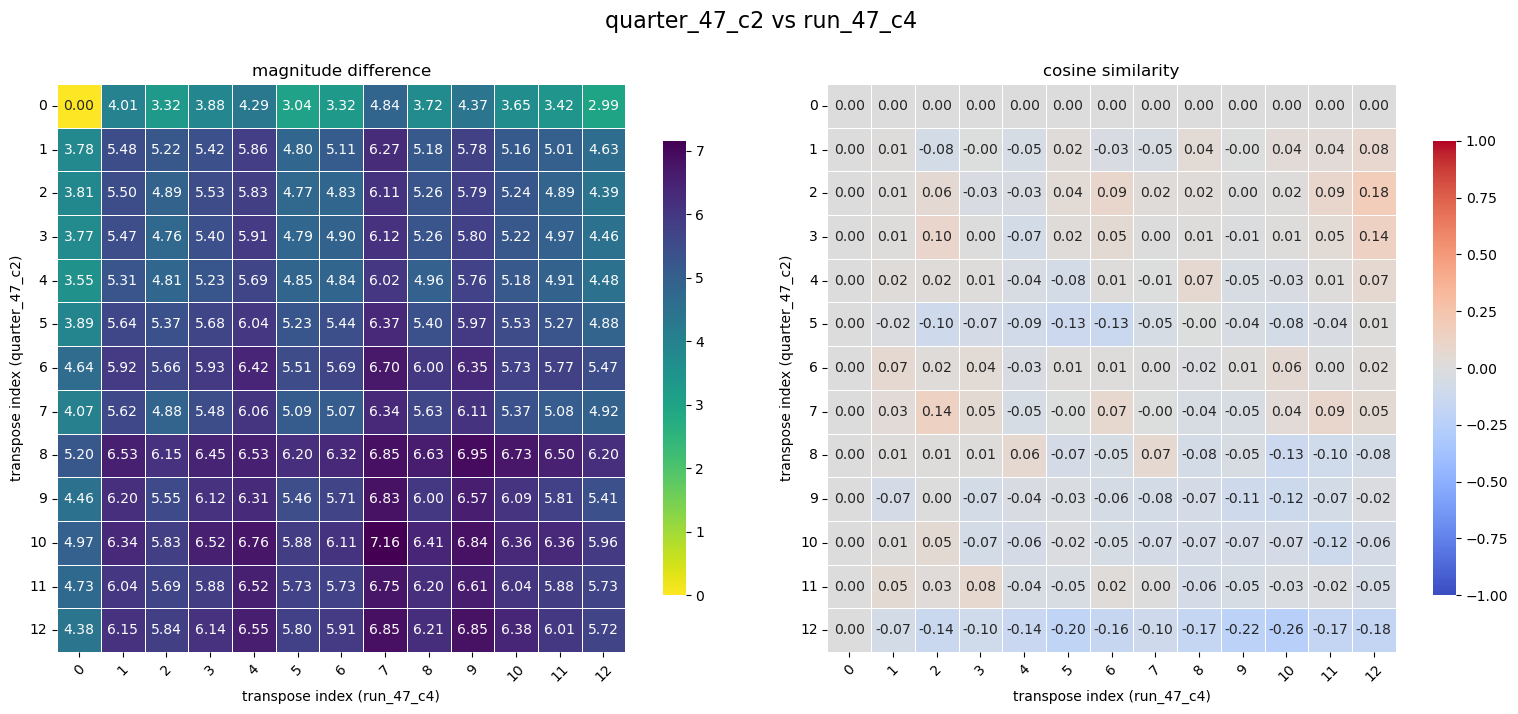

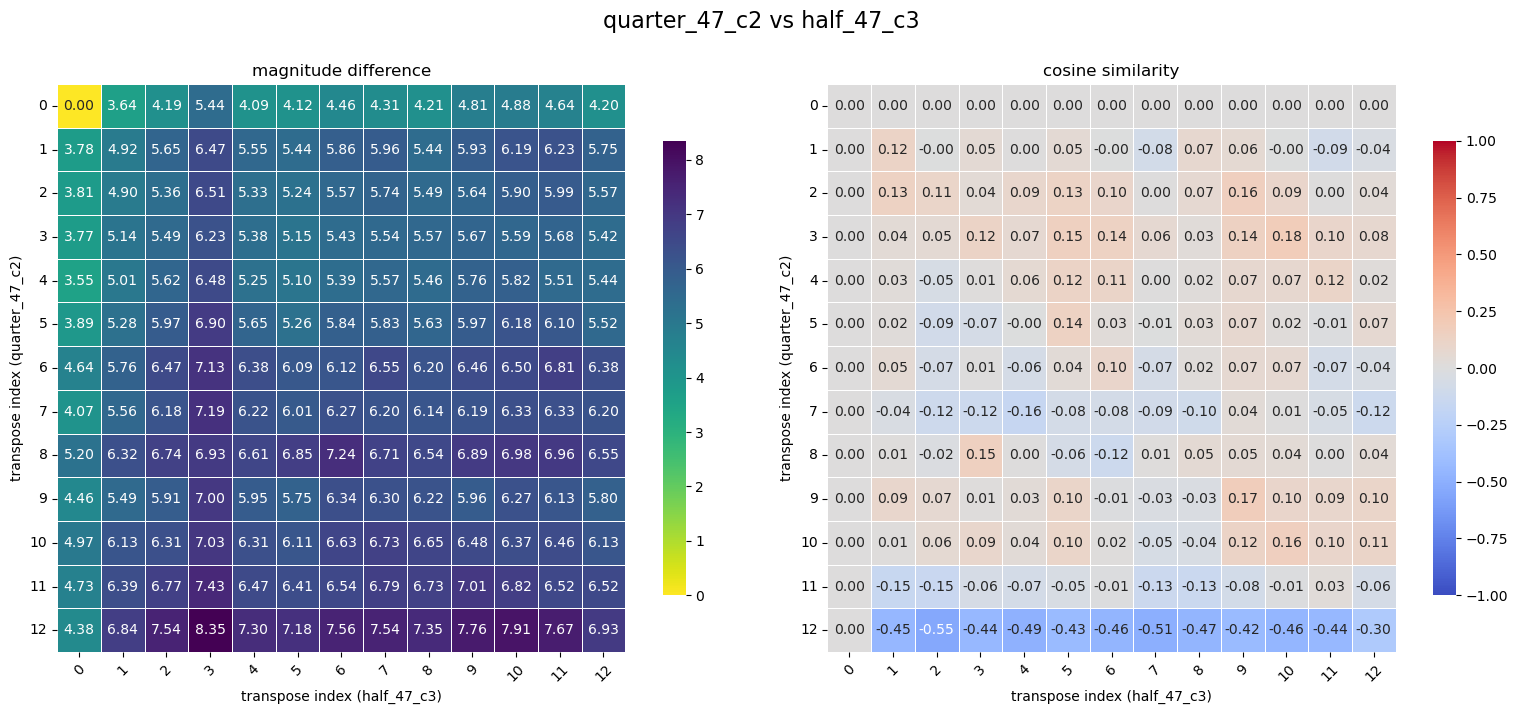

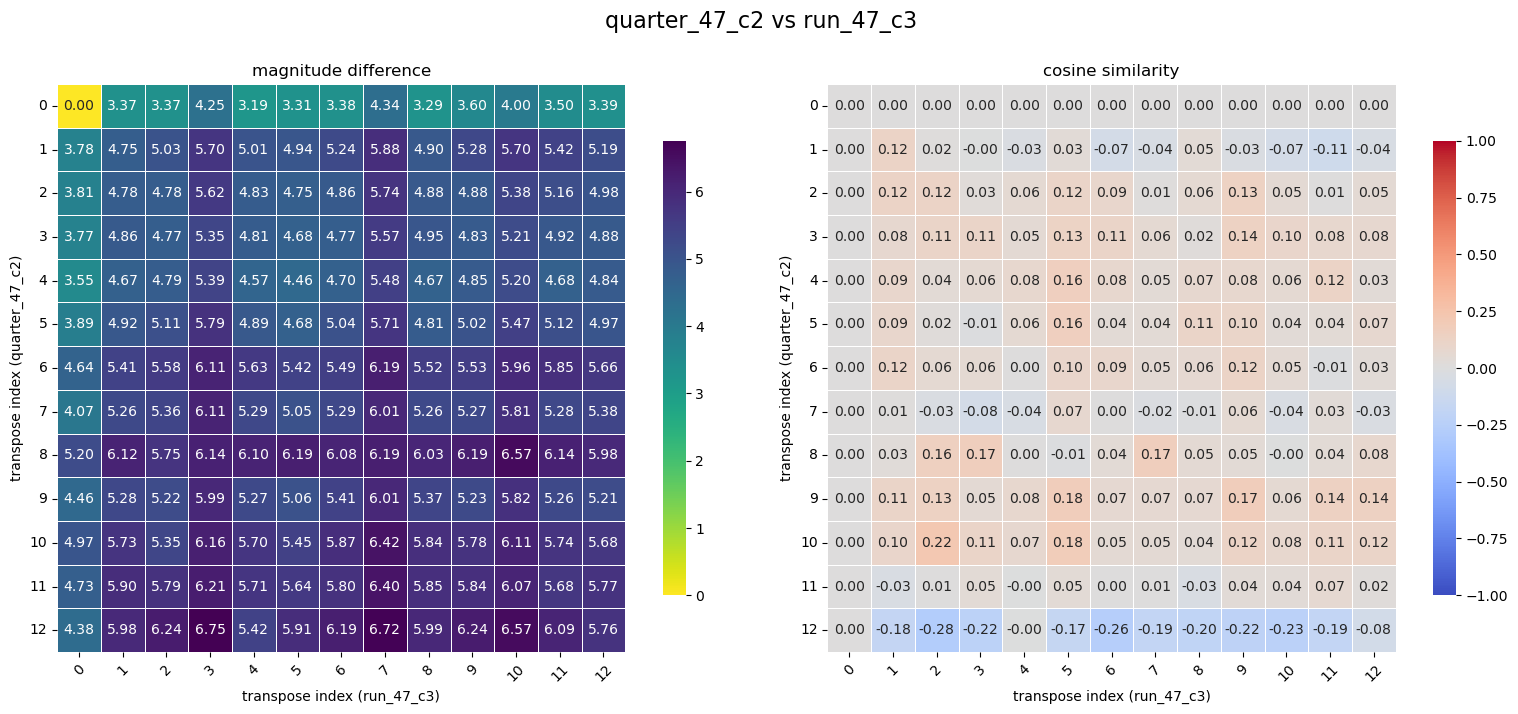

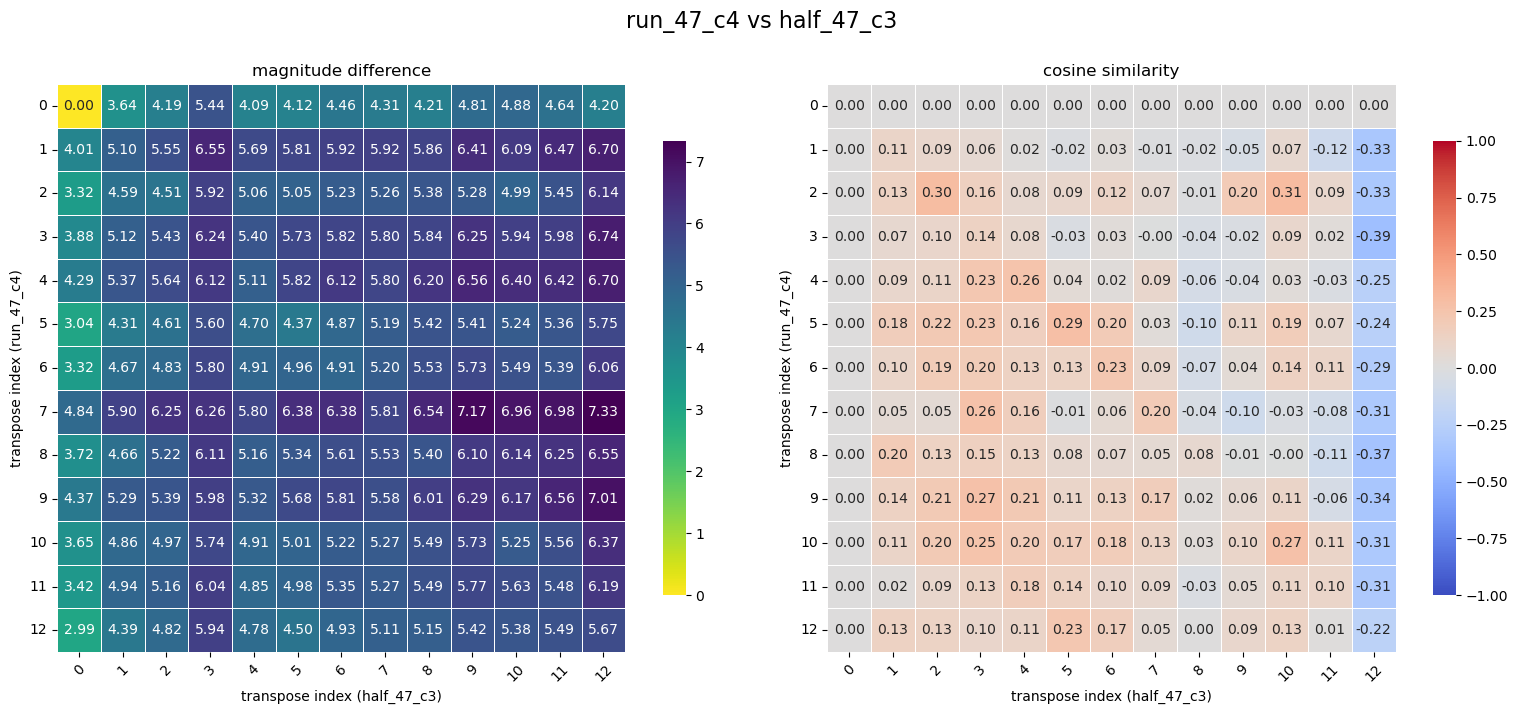

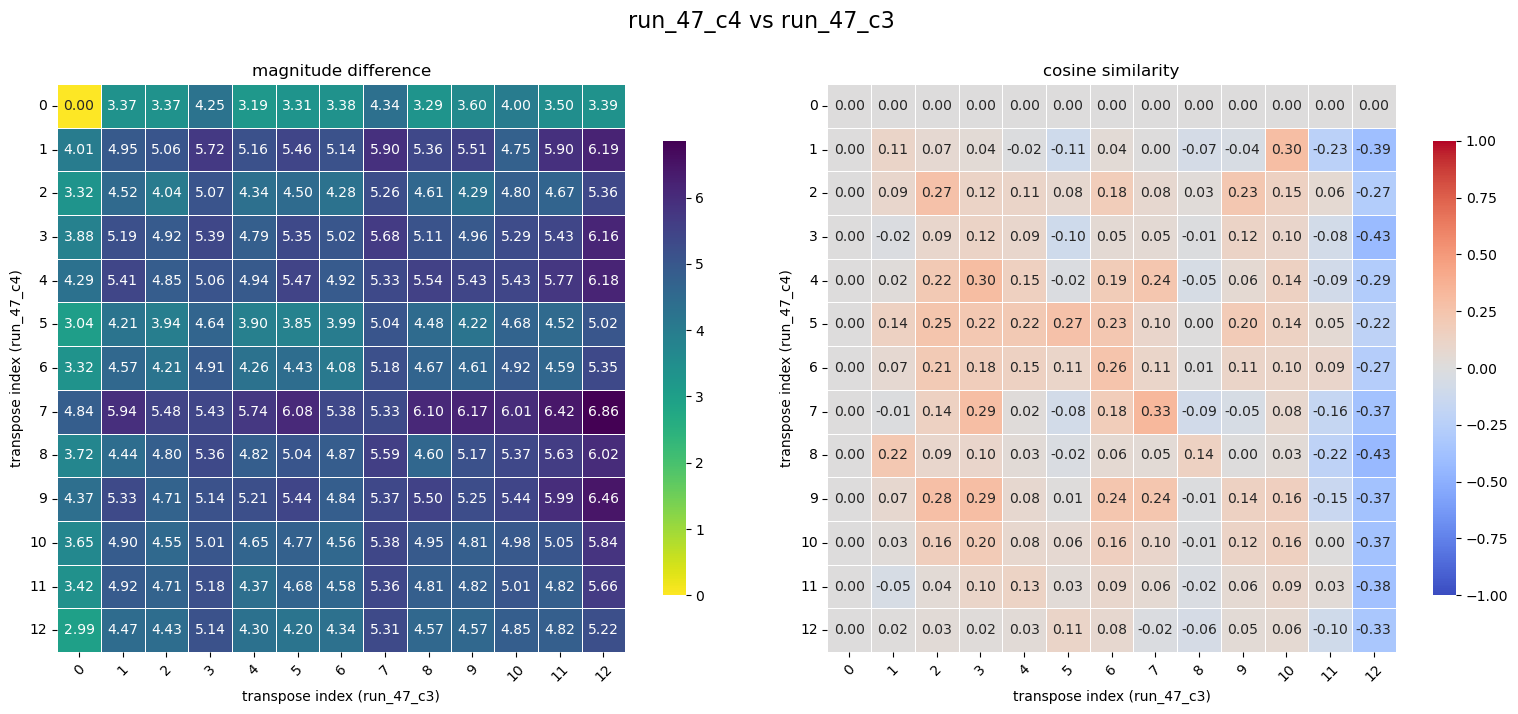

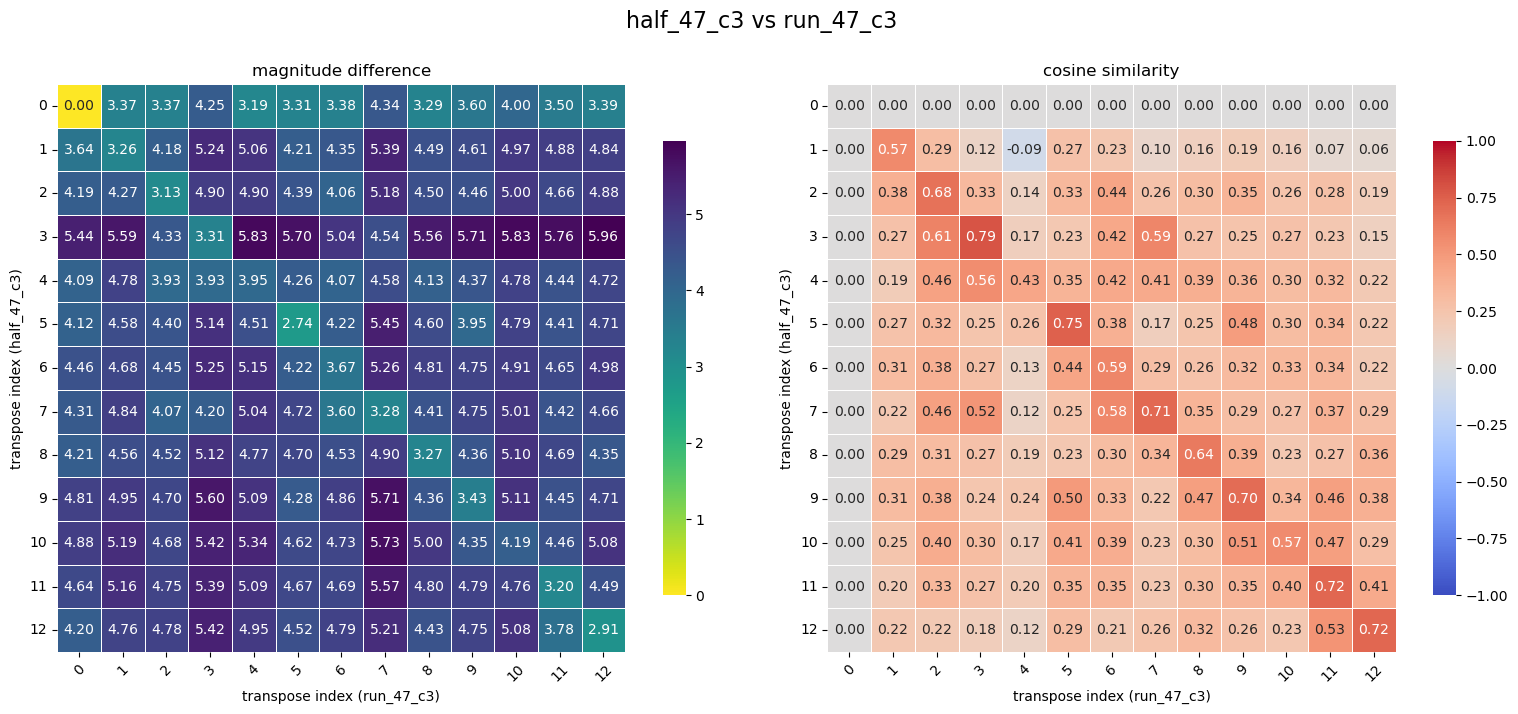

In [38]:
random_subset = np.random.choice(range(13), 4, replace=False)
plot_heatmaps(
    np.array([all_diffs[i] for i in random_subset]),
    [basename(chosen_files[i]) for i in random_subset],
    list(range(13)),
)

woah, ok, so a few things i notice:
1. generally uncorrelated
2. if one file is transposed enough that it is in the same octave as the other we see *some* correlation, but it's a negative similarity? thats the opposite of what i had hoped for.
3. once we compare two files from the same octave we see a much stronger correlation between delta vectors

## second phase
one thought i had was that maybe deltas change depending on where on the keyboard we are, i.e. a delta vector of a note near the bottom of the piano roll being transposed upwards could be different from the same transposition of a note near the top of the piano roll. So, **not** chroma, but *pitch histograms* could be used. lets now align all the notes so that they are in the same area of the piano roll.

### alignment

Reference file for alignment: full_47_c2


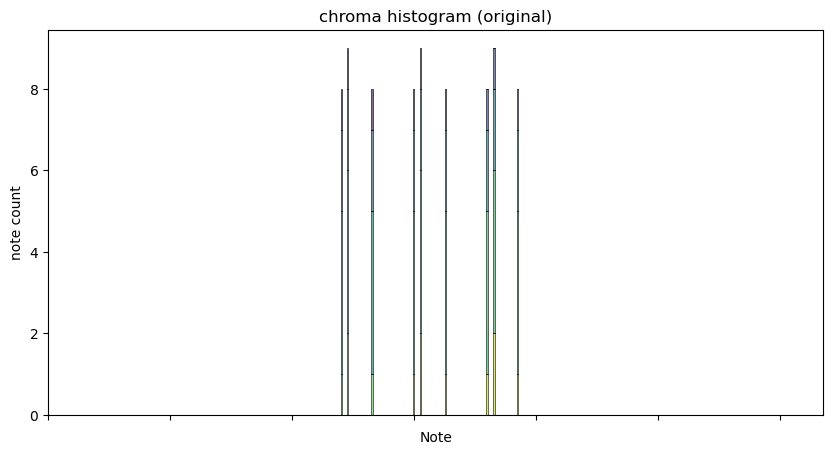

In [39]:
# --- Calculate Optimal Transpositions ---
optimal_offsets = {}
first_file = chosen_files[0]
print(f"Reference file for alignment: {basename(first_file)}")
hists = [get_pitch_histogram(f, normalize=False) for f in chosen_files]
hist_0 = get_pitch_histogram(first_file)

# Create a dataframe for the stacked histogram
hist_data = []
for i, hist in enumerate(hists):
    for note_idx, count in enumerate(hist):
        if count > 0:  # Only include non-zero values
            hist_data.append({"Note": note_idx, "Count": count, "File": f"File {i+1}"})

hist_df = pd.DataFrame(hist_data)
# Create a figure for stacked histogram
fig, ax_hist1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot stacked histogram using seaborn
sns.histplot(
    data=hist_df,
    x="Note",
    weights="Count",
    stat="count",
    hue="File",
    multiple="stack",
    palette="viridis",
    alpha=0.7,
    ax=ax_hist1,
    bins=128,
    legend=False,
)

ax_hist1.set_xlim(0, 127)
ax_hist1.set_xticklabels([])
ax_hist1.set_title("chroma histogram (original)")
ax_hist1.set_ylabel("note count")
fig.show()

here are all the segments as they are, without transposition, notes stacked

In [40]:
aligned_hists = []
for i, current_file in enumerate(chosen_files):
    hist_i = get_pitch_histogram(current_file)
    min_kl = float("inf")
    best_offset = 0
    possible_offsets = range(-24, 25)  # +/- 2 octaves

    for offset in possible_offsets:
        shifted_hist_i = shift_histogram(hist_i, offset)
        kl_div = calculate_kl_divergence(shifted_hist_i, hist_0)
        # print(f"  Offset {offset}: KL={kl_div:.4f}")
        if kl_div < min_kl:
            min_kl = kl_div
            best_offset = offset

    print(f"found optimal offset for '{basename(current_file)}': {best_offset}")
    aligned_hists.append(
        shift_histogram(get_pitch_histogram(current_file, normalize=False), best_offset)
    )
    optimal_offsets[current_file] = best_offset

found optimal offset for 'full_47_c2': 0
found optimal offset for 'full_47_c3': -12
found optimal offset for 'full_47_c4': -24
found optimal offset for 'half_47_c2': 0
found optimal offset for 'half_47_c3': -12
found optimal offset for 'half_47_c4': -24
found optimal offset for 'quarter_47_c2': 0
found optimal offset for 'quarter_47_c3': -12
found optimal offset for 'quarter_47_c4': -24
found optimal offset for 'run_47_c2': 0
found optimal offset for 'run_47_c3': -12
found optimal offset for 'run_47_c4': -24


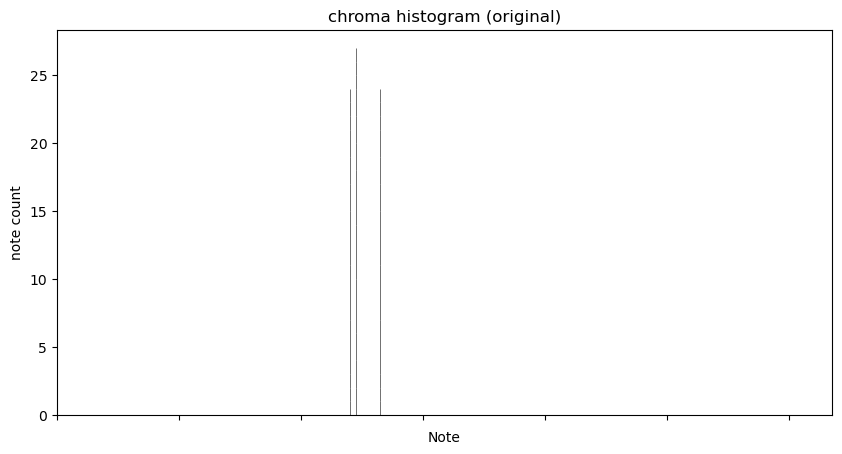

In [41]:
# Create a dataframe for the stacked histogram
hist_data = []
for i, hist in enumerate(aligned_hists):
    for note_idx, count in enumerate(hist):
        if count > 0:  # Only include non-zero values
            hist_data.append({"Note": note_idx, "Count": count, "File": f"File {i+1}"})

aligned_hist_df = pd.DataFrame(hist_data)
# Create a figure for stacked histogram
fig, ax_hist1 = plt.subplots(1, 1, figsize=(10, 5))

# Plot stacked histogram using seaborn
sns.histplot(
    data=aligned_hist_df,
    x="Note",
    weights="Count",
    stat="count",
    hue="File",
    multiple="stack",
    palette="viridis",
    alpha=0.7,
    ax=ax_hist1,
    bins=128,
    legend=False,
)

ax_hist1.set_xlim(0, 127)
ax_hist1.set_xticklabels([])
ax_hist1.set_title("chroma histogram (original)")
ax_hist1.set_ylabel("note count")
fig.show()

transpose them all so they align. since they are all composed of the same three notes we get perfect alignment.

### per file plots
Recalculate Embeddings and Differences using Aligned Base


Processing aligned base file: /media/scratch/sageev-midi/teeny/ccsf/full_47_c2.mid
  Transposing full_47_c2 by 0 semitones to full_47_c2t00s00
  Results relative to base aligned by 0 semitones:
 Transposition  Magnitude Difference  Cosine Difference
             0              0.000000       5.960464e-08
             1              2.899915       3.515130e-01
             2              3.753779       5.696922e-01
             3              3.835794       5.723501e-01
             4              4.325619       6.486064e-01
             5              3.483631       4.917043e-01
             6              4.003836       6.344549e-01
             7              3.507203       5.292104e-01
             8              4.508969       7.482967e-01
             9              3.829626       5.974175e-01
            10              4.191846       7.167993e-01
            11              4.105251       6.785045e-01
            12              3.924474       6.027777e-01
----------------------

  Results relative to base aligned by -24 semitones:
 Transposition  Magnitude Difference  Cosine Difference
             0              0.000000           0.000000
             1              3.778354           0.544251
             2              3.807804           0.591889
             3              3.767850           0.599503
             4              3.554845           0.517998
             5              3.892290           0.577594
             6              4.642362           0.802138
             7              4.073980           0.652342
             8              5.204943           0.838497
             9              4.461523           0.730241
            10              4.968020           0.881784
            11              4.725903           0.818012
            12              4.380152           0.715064
----------------------------------------------------------------------
Processing aligned base file: /media/scratch/sageev-midi/teeny/ccsf/run_47_c2.mid
  Transpos

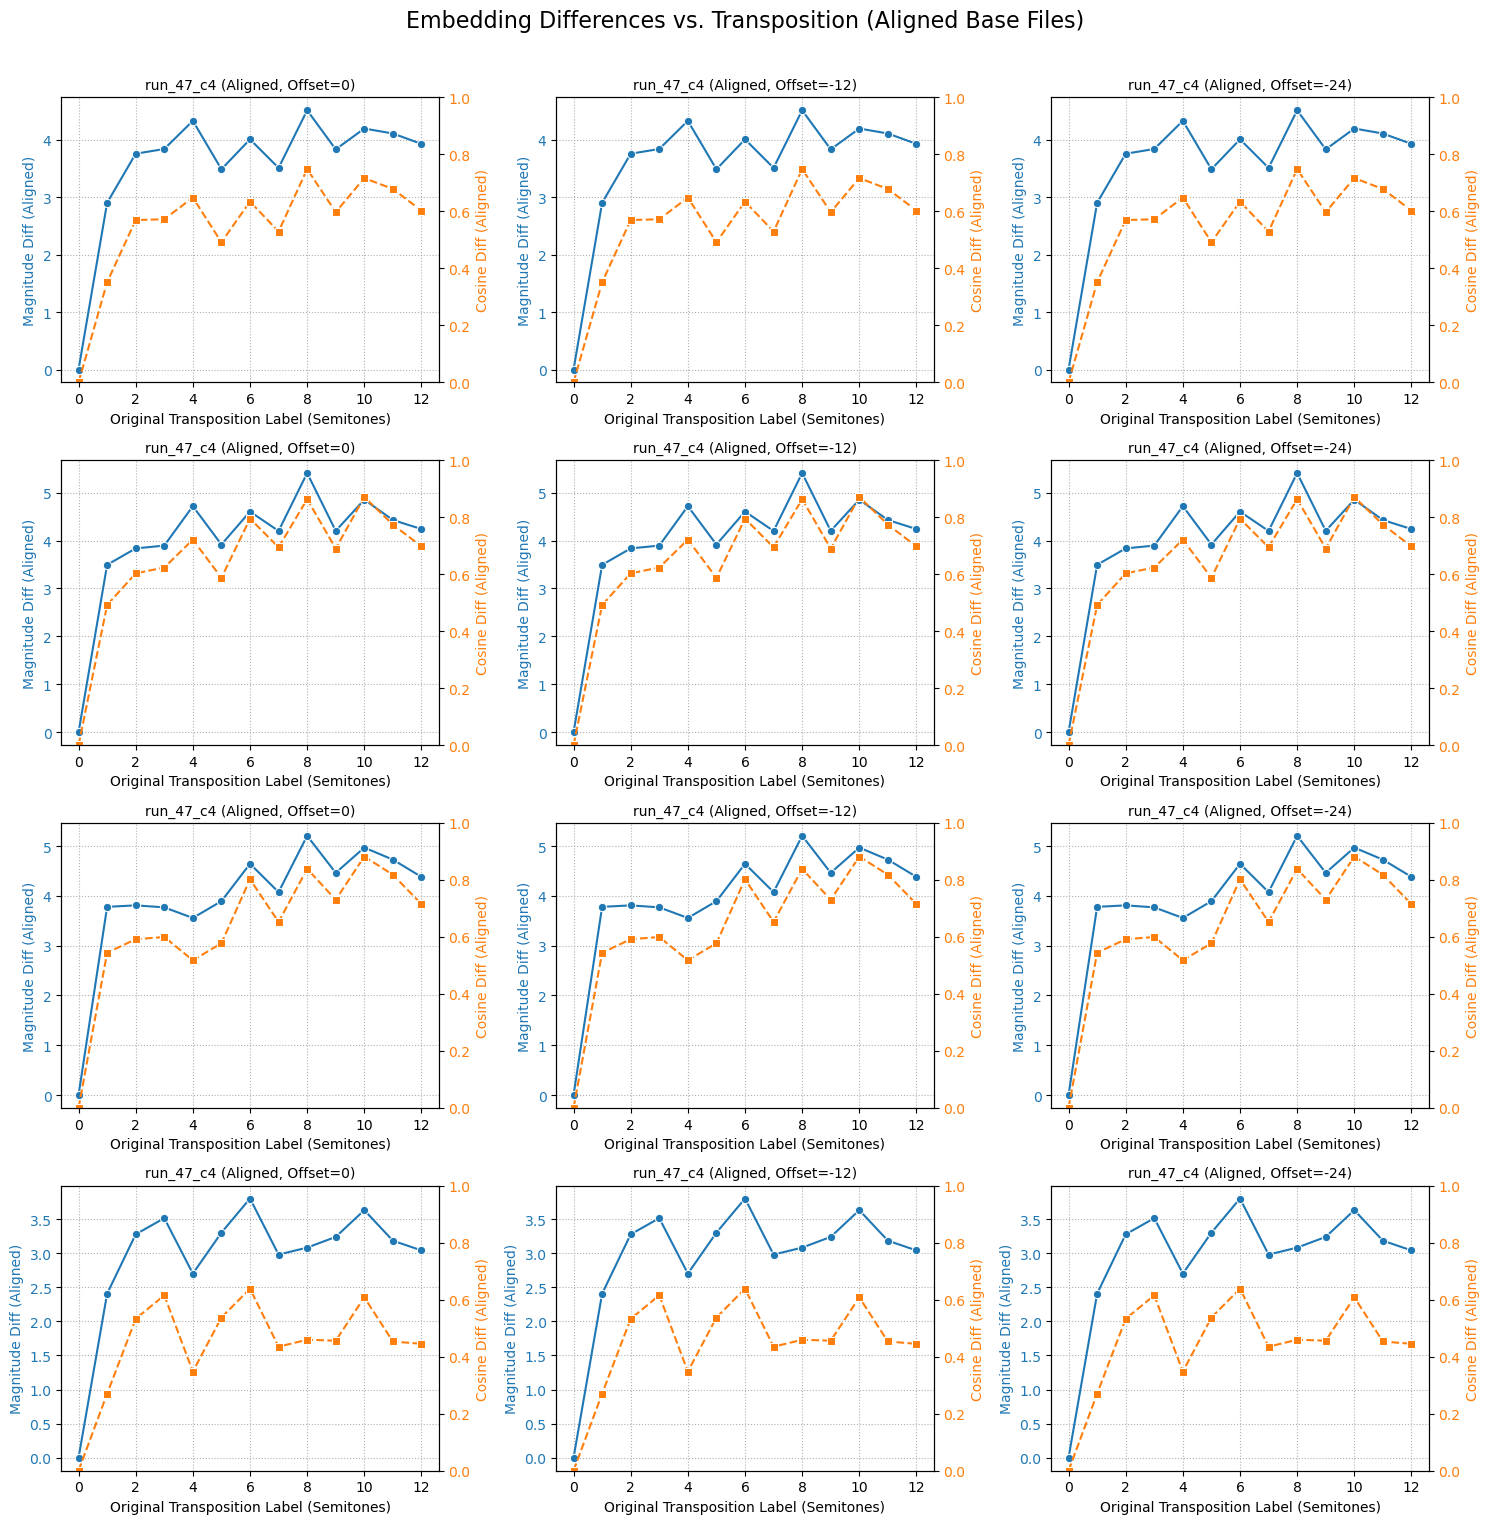

In [42]:
aligned_results = []
# Plotting setup for individual aligned files
fig_individual_aligned, axes_individual_aligned = plt.subplots(
    n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False
)
axes_individual_aligned = axes_individual_aligned.flatten()

aligned_diffs = np.zeros((n_files, 13, 768))
aligned_names = []

for i, base_file in enumerate(chosen_files):
    print(f"Processing aligned base file: {base_file}")
    offset = optimal_offsets[base_file]
    offset_name = basename(base_file) + f"t{offset:02d}s00.mid"
    # offset_name = basename(base_file).replace("t00s00", f"t{offset:02d}s00.mid")
    aligned_file_path = os.path.join(TMP_DIR, offset_name)
    aligned_names.append(basename(offset_name))
    # first transpose the file by the optimal offset
    try:
        print(
            f"  Transposing {basename(base_file)} by {offset} semitones to {basename(aligned_file_path)}"
        )
        transpose_midi(base_file, aligned_file_path, offset)
        aligned_base_embedding = model.embed(aligned_file_path).squeeze().flatten()
        aligned_base_embedding = aligned_base_embedding.flatten()
    except Exception as e:
        print(f"  Error processing aligned base {basename(aligned_file_path)}: {e}")
        continue
    aligned_diffs[i, 0, :] = np.zeros_like(aligned_base_embedding)

    # rename the transpositions based on offset
    transposed_files = [
        (
            os.path.join(TMP_DIR, basename(base_file) + f"t{offset + t:02d}.mid"),
            offset + t,
        )
        for t in range(13)
    ]
    results_aligned = []
    for j, (tmp_path, transposition) in enumerate(transposed_files):
        # print(f"    Generating embedding for transposition {transposition}: {basename(tmp_path)}")

        # Ensure we transpose the *original* t00 base file
        # print(f"transposing {base_file} by {transposition} to {tmp_path}")
        transpose_midi(base_file, tmp_path, transposition)
        transposed_embedding = model.embed(tmp_path).squeeze()

        # Calculate difference relative to the ALIGNED base embedding
        diff_vector = transposed_embedding - aligned_base_embedding
        aligned_diffs[i, j, :] = diff_vector
        magnitude_diff = norm(diff_vector)
        cosine_sim = np.dot(aligned_base_embedding, transposed_embedding) / (
            norm(aligned_base_embedding) * norm(transposed_embedding)
        )

        # Ensure cosine similarity is within [-1, 1]
        cosine_sim = np.clip(cosine_sim, -1.0, 1.0)
        cosine_diff = 1 - cosine_sim

        results_aligned.append(
            {
                "Transposition": transposition - offset,  # Original transposition label
                "Magnitude Difference": magnitude_diff,
                "Cosine Difference": cosine_diff,
                "File": basename(base_file),
                "Aligned Base Offset": offset,  # Store the offset used for the base
            }
        )

    # Sort results by transposition for consistent table/plotting
    results_aligned.sort(key=lambda x: x["Transposition"])

    # Print table for the current aligned base file
    df_results_aligned = pd.DataFrame(results_aligned)
    print(f"  Results relative to base aligned by {offset} semitones:")
    print(
        df_results_aligned.to_string(
            index=False,
            columns=["Transposition", "Magnitude Difference", "Cosine Difference"],
        )
    )
    print("-" * 70)

    # Add base file info to results before extending the main list
    for res in results_aligned:
        res["BaseFile"] = base_name_prefix  # Original base file identifier

    # Store for aggregate plot
    aligned_results.extend(results_aligned)

    # Plotting for individual file (aligned)
    ax = axes_individual_aligned[i]
    plot_individual_difference(
        ax,
        df_results_aligned,
        base_name_prefix,
        offset=offset,
        mag_label="Magnitude Diff (Aligned)",
        cos_label="Cosine Diff (Aligned)",
    )

fig_individual_aligned.suptitle(
    "Embedding Differences vs. Transposition (Aligned Base Files)", fontsize=16
)
fig_individual_aligned.tight_layout(rect=(0, 0.03, 1, 0.97))
fig_individual_aligned.show()

each plot having the same filename in the title is a bug. but look at how well aligned they are now! we expect them to be identical from left to right, since they are the same file, but the top three files all exhibit similarspikes and drops at the same transpositions. neat. 

### aggregate plot

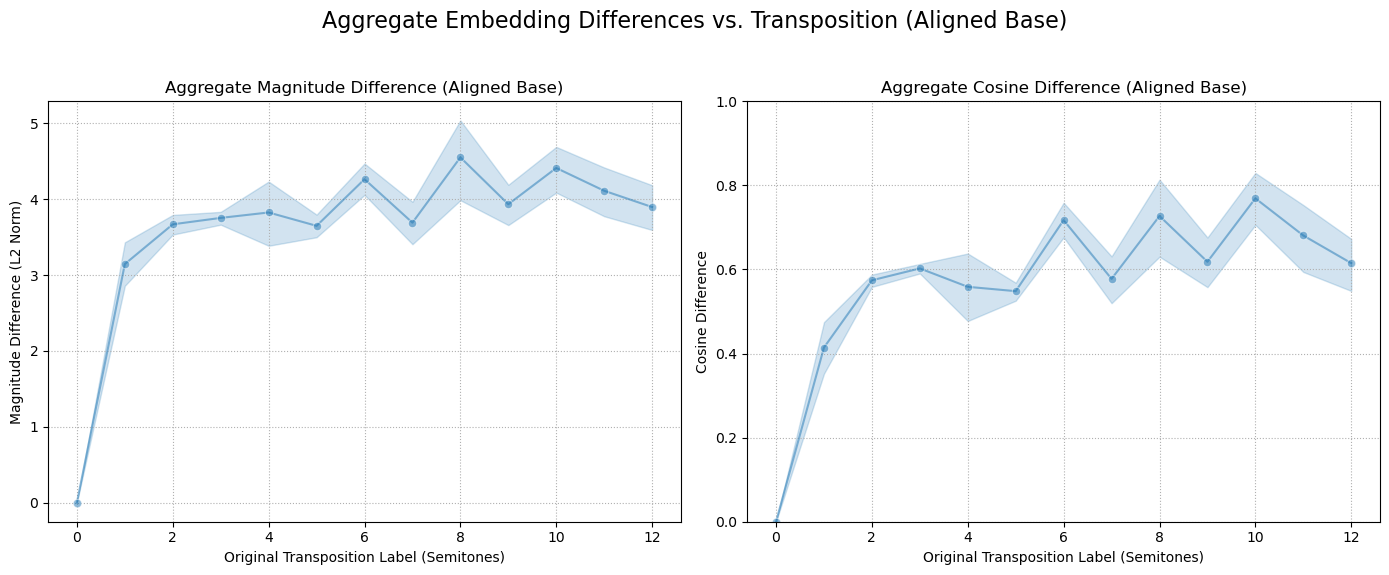

In [43]:
df_all_aligned = pd.DataFrame(aligned_results)
fig_agg_aligned, ax_agg_aligned = plt.subplots(1, 2, figsize=(14, 6))

# Aggregate Magnitude Difference Plot (Aligned)
sns.lineplot(
    data=df_all_aligned,
    x="Transposition",
    y="Magnitude Difference",
    hue="BaseFile",  # Color by original base file group
    ax=ax_agg_aligned[0],
    alpha=0.5,
    marker="o",
    legend=False,
)
ax_agg_aligned[0].set_title("Aggregate Magnitude Difference (Aligned Base)")
ax_agg_aligned[0].set_xlabel("Original Transposition Label (Semitones)")
ax_agg_aligned[0].set_ylabel("Magnitude Difference (L2 Norm)")
ax_agg_aligned[0].grid(True, linestyle=":")

# Aggregate Cosine Difference Plot (Aligned)
sns.lineplot(
    data=df_all_aligned,
    x="Transposition",
    y="Cosine Difference",
    hue="BaseFile",  # Color by original base file group
    ax=ax_agg_aligned[1],
    alpha=0.5,
    marker="o",
    legend=False,
)
ax_agg_aligned[1].set_title("Aggregate Cosine Difference (Aligned Base)")
ax_agg_aligned[1].set_xlabel("Original Transposition Label (Semitones)")
ax_agg_aligned[1].set_ylim(0, 1)
ax_agg_aligned[1].set_ylabel("Cosine Difference")
ax_agg_aligned[1].grid(True, linestyle=":")

fig_agg_aligned.suptitle(
    "Aggregate Embedding Differences vs. Transposition (Aligned Base)",
    fontsize=16,
)
fig_agg_aligned.tight_layout(rect=(0, 0.03, 1, 0.95))
fig_agg_aligned.show()

### direct delta comparisons

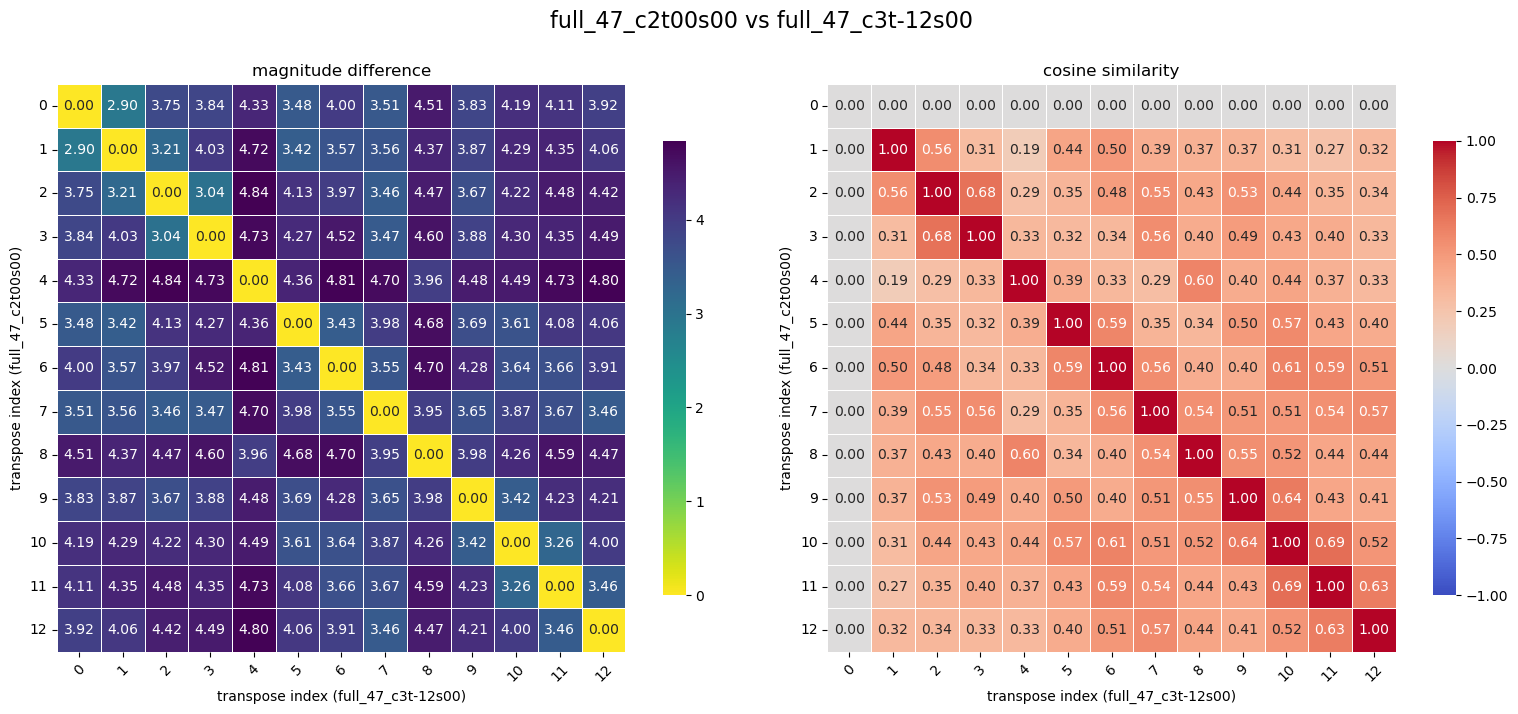

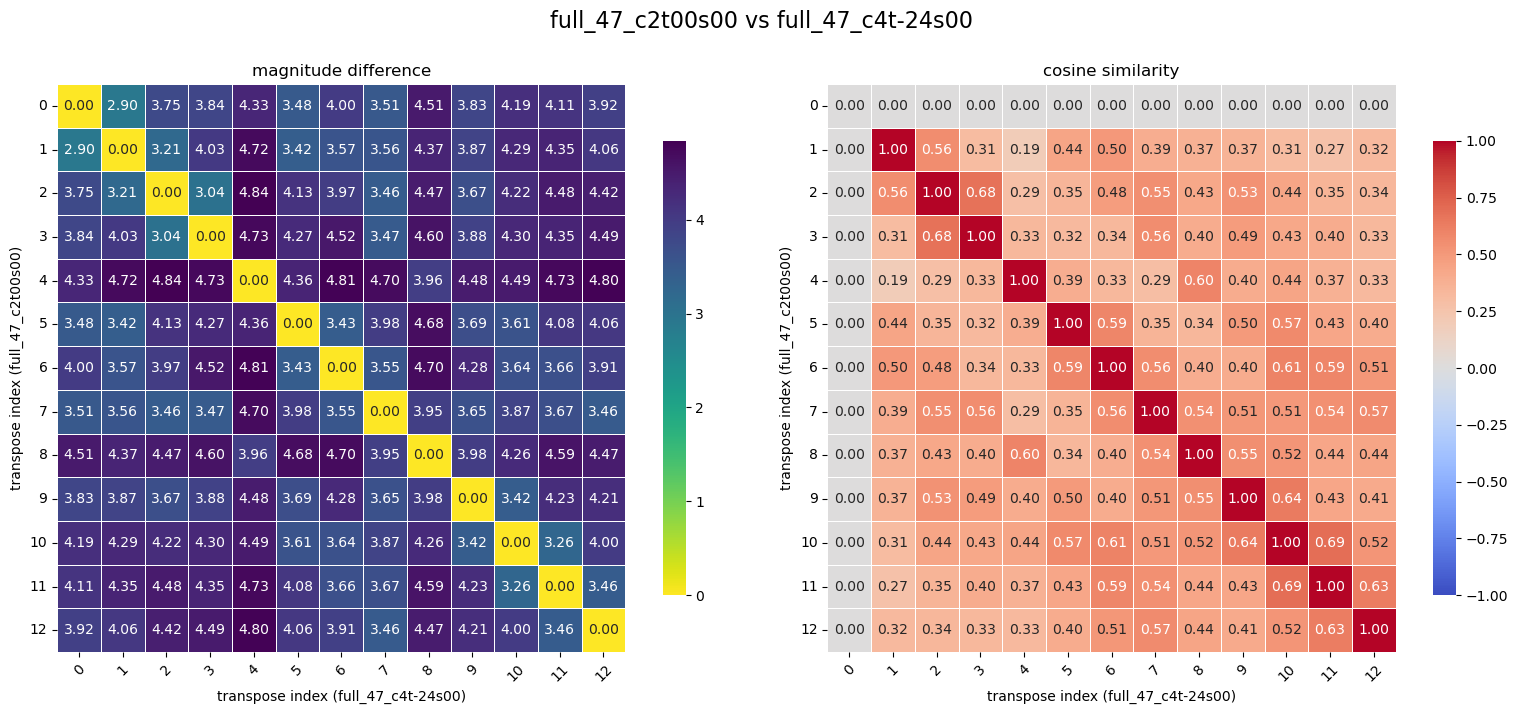

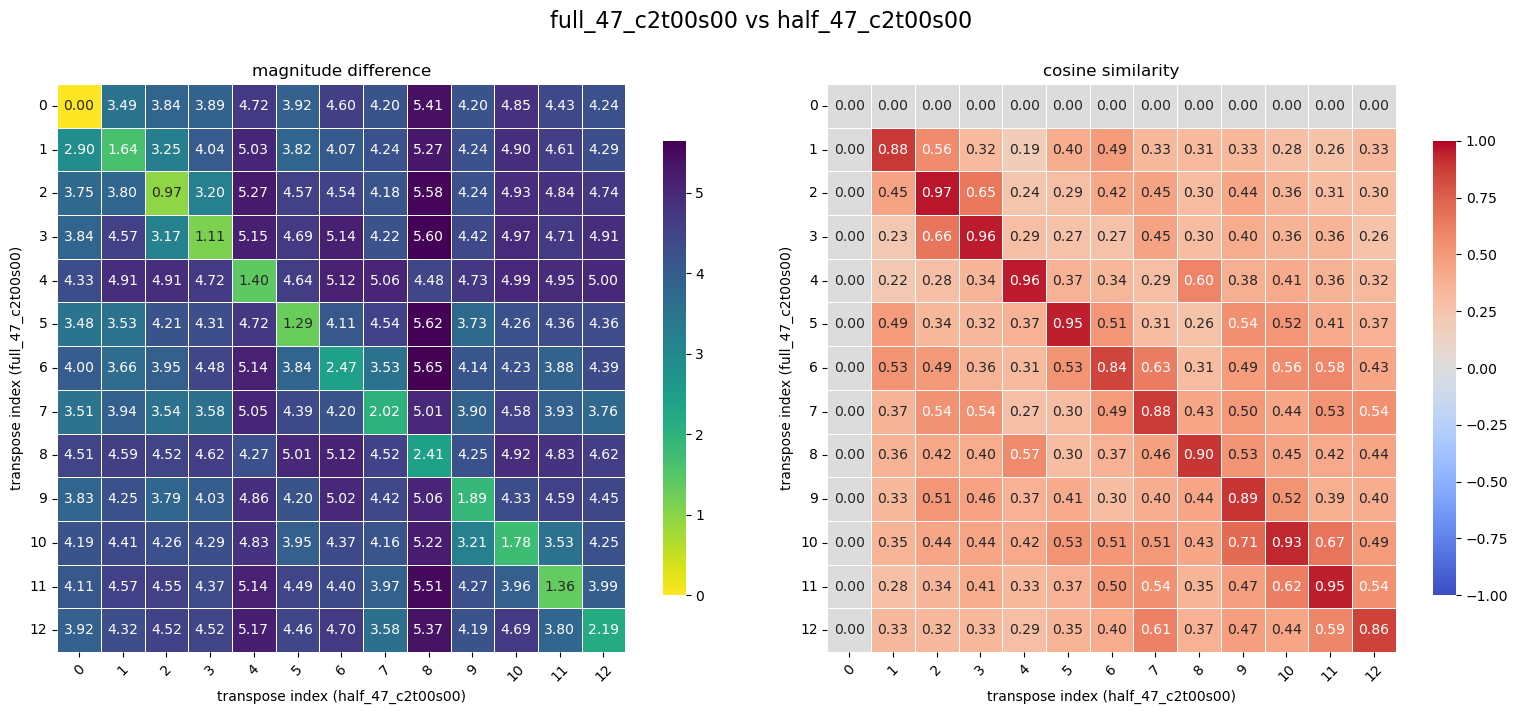

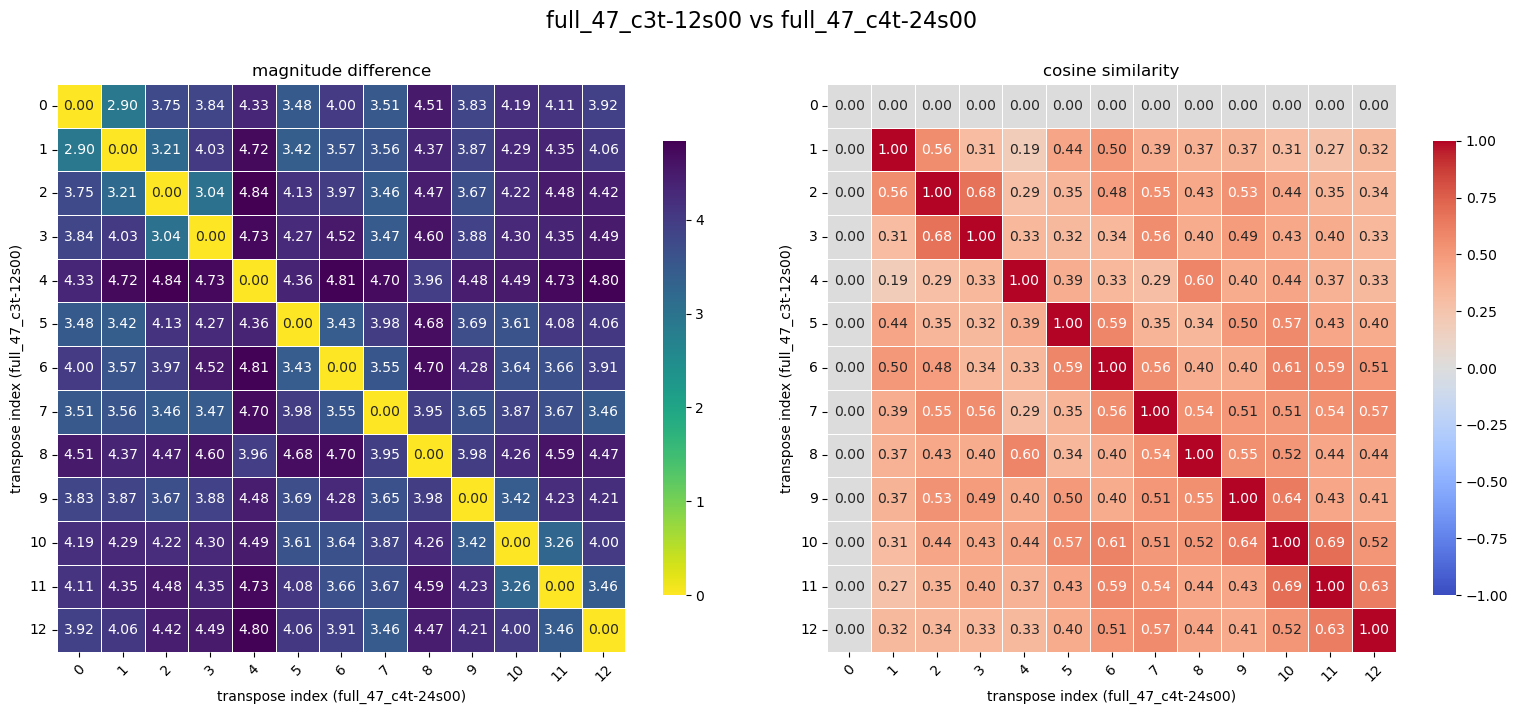

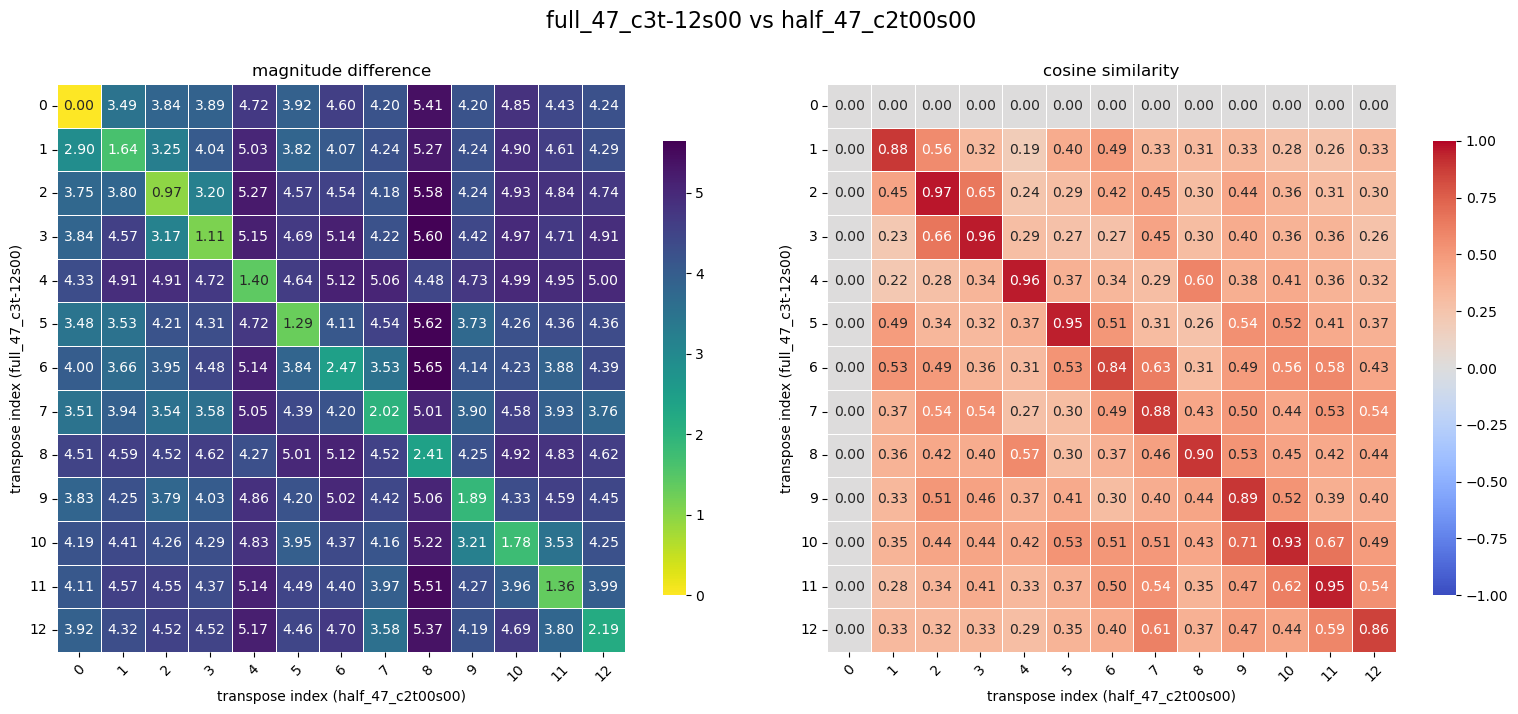

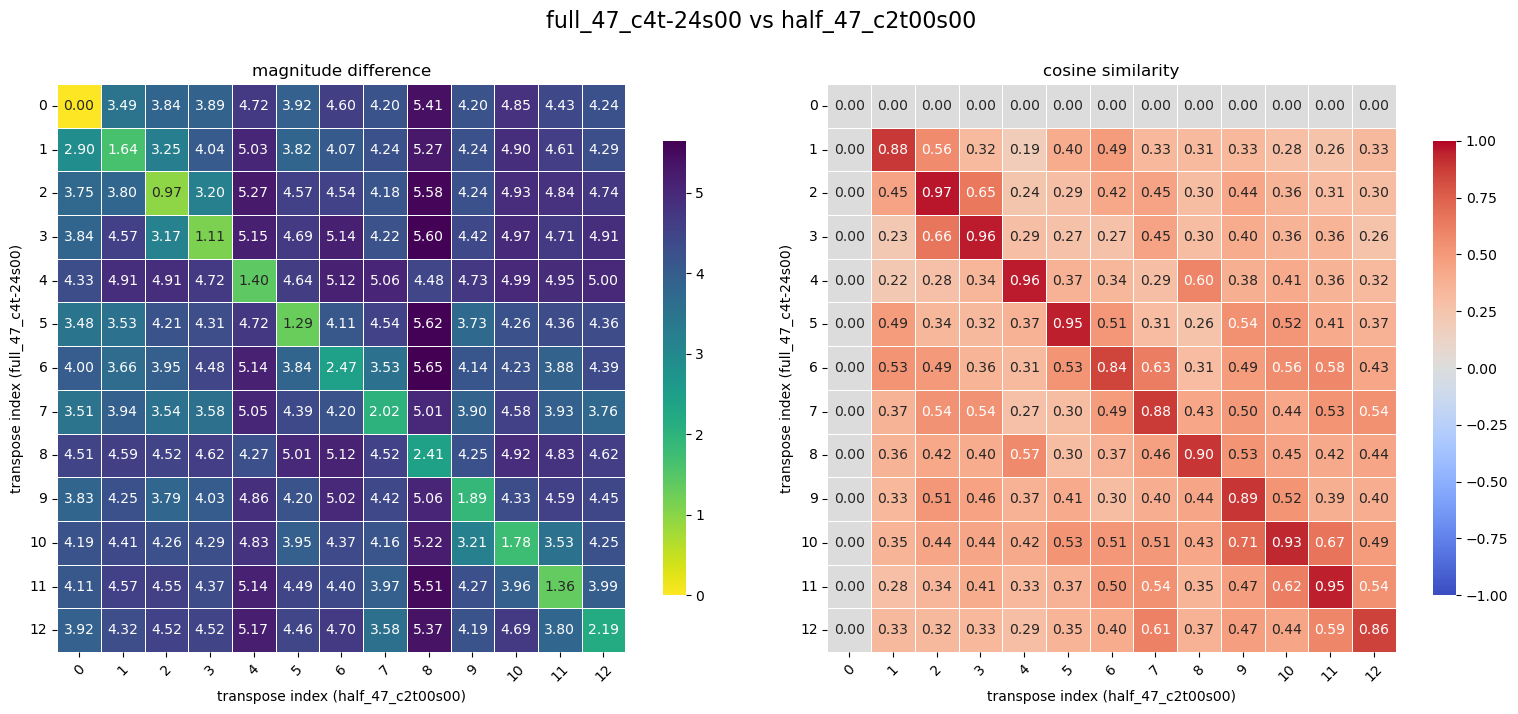

In [44]:
plot_heatmaps(aligned_diffs[:4], aligned_names[:4], list(range(13)))

alignment is way stronger. still not perfect, as we saw with the per-file plots, but much stronger.